In [2]:
import requests
import pandas as pd
import bs4
import PIL.Image as Image
import collections
import os
from multiprocessing import Pool
import tqdm.notebook as tqdm
from datetime import timedelta, date

In [3]:
#Loading flickr key
with open("private/flickr-id.txt") as f:
    key = f.readlines()[0][:-1]

In [4]:
#testing the connection:
res = requests.get(f"https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key={key}&tags=polytechnique&per_page=50&page=1&extras=url_o,o_dims,original_format,tags")
assert res.status_code == 200

## Downloading meta data in CSV

In [189]:
def get_range_pictures(tag, date_range):
    min_date,max_date = date_range
    total = None
    count = 0
    d = collections.defaultdict(list)
    while total is None or (count < total and count < 5):
        res = requests.get(f"https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key={key}&tags={tag}&per_page=500&page={count}&min_upload_date={min_date}&max_upload_date={max_date}&sort=date-posted-desc&extras=url_o,o_dims,original_format,tags,license")
        soup = bs4.BeautifulSoup(res.text)
        #return(soup,res)
        gen_infos = soup.find("photos")
        if total is None:
            total = int(gen_infos["pages"])
        photos_info = soup.find_all("photo")
        for image_info in photos_info:
            if "id" not in image_info.attrs:
                print("weird")
                return pd.DataFrame()
            d["id"].append(image_info["id"])
            d["server"].append(image_info["server"])
            d["secret"].append(image_info["secret"])
            d["height_o"].append(image_info["height_o"] if "height_o" in image_info.attrs else None)
            d["width_o"].append(image_info["width_o"] if "width_o" in image_info.attrs else None)
            d["tags"].append(image_info["tags"])
            d["license"].append(image_info["license"] if "license" in image_info.attrs else None)
            d["title"].append(image_info["title"])
            d["url_o"].append(image_info["url_o"] if "url_o" in image_info.attrs else None)
            d["owner"].append(image_info["owner"])
        count += 1
    dataset = pd.DataFrame(d)
    print(f"Found {total} pages, with {dataset['id'].nunique()} unique pictures")
    return dataset

In [151]:
year_start = date(2015,1,1)
date_ranges = [(year_start + timedelta(n), year_start + timedelta(n+1)) for n in range(365)]

In [193]:
res = []
total_images = set()

177140

In [195]:
tag = "dog"
for r in tqdm.tqdm(date_ranges[150:]):
    new_images = get_range_pictures(tag, r)
    if "id" in new_images.columns:
        total_images.update(new_images['id'].unique())
    print(f"{len(total_images)} total images")
    res.append(new_images)

Found 2 pages, with 528 unique pictures
117913 total images
Found 2 pages, with 628 unique pictures
118541 total images
Found 3 pages, with 1124 unique pictures
119665 total images
Found 2 pages, with 638 unique pictures
120303 total images
Found 2 pages, with 613 unique pictures
120916 total images
Found 2 pages, with 534 unique pictures
121450 total images
Found 3 pages, with 1071 unique pictures
122521 total images
Found 3 pages, with 1111 unique pictures
123632 total images
Found 2 pages, with 653 unique pictures
124285 total images
Found 2 pages, with 656 unique pictures
124941 total images
Found 2 pages, with 609 unique pictures
125550 total images
Found 2 pages, with 595 unique pictures
126145 total images
Found 2 pages, with 554 unique pictures
126699 total images
Found 2 pages, with 630 unique pictures
127329 total images
Found 2 pages, with 653 unique pictures
127982 total images
Found 2 pages, with 615 unique pictures
128597 total images
Found 2 pages, with 610 unique pictur

Found 2 pages, with 555 unique pictures
222227 total images
Found 2 pages, with 545 unique pictures
222772 total images
Found 2 pages, with 583 unique pictures
223355 total images
Found 3 pages, with 1038 unique pictures
224393 total images
Found 3 pages, with 1139 unique pictures
225532 total images
Found 3 pages, with 969 unique pictures
226499 total images
Found 2 pages, with 655 unique pictures
227154 total images
Found 2 pages, with 546 unique pictures
227700 total images
Found 2 pages, with 670 unique pictures
228370 total images
Found 2 pages, with 581 unique pictures
228951 total images
Found 2 pages, with 639 unique pictures
229590 total images
Found 4 pages, with 1466 unique pictures
231056 total images
Found 2 pages, with 571 unique pictures
231627 total images
Found 2 pages, with 715 unique pictures
232342 total images
Found 2 pages, with 550 unique pictures
232892 total images
Found 2 pages, with 654 unique pictures
233546 total images
Found 2 pages, with 619 unique pictur

In [196]:
dataset2015 = pd.concat(res)
dataset2015 = dataset2015.drop_duplicates().reset_index(drop=True)

In [199]:
#dataset2015.to_csv("data/metadata/dog_metadata_raw_2015.csv")

## Downloading images

In [201]:
def download_image_1024(im_row, im_path):
    server_id  = im_row["server"]
    im_id  = im_row["id"]
    secret  = im_row["secret"]
    size_suffix  = "b"
    im_res = requests.get(f"https://live.staticflickr.com/{server_id}/{im_id}_{secret}_{size_suffix}.jpg")
    if im_res.status_code == 200:
        with open(im_path , "wb") as f:
            f.write(im_res.content)
            #print("Done", im_id)
    else:
        print("error downloading", im_id)

def download(im_row, download_path="data/dogs-1024-2015"):
        im_id  = im_row["id"]
        im_path = os.path.join(download_path, f"{im_id}.jpg")
        if not os.path.isfile(im_path):
            download_image_1024(im_row, im_path)
        
def download_dataset(dataset, process=4):
    with Pool(process) as p:
        p.map(download, [ir[1] for ir in dataset.iterrows()])

In [6]:
dataset = pd.read_csv("data/metadata/dog_metadata_raw_2015.csv", index_col=0)
print(len(dataset))

274800


In [204]:
download_dataset(dataset[:5000])

In [215]:
'16123773509' in dataset['id']

False

In [216]:
len(dataset)

274800

In [217]:
download_dataset(dataset[5000:100000])

error downloading 16489042186
error downloading 16719842955
error downloading 16474456821
error downloading 16248791578
error downloading 16746337612
error downloading 16745128126
error downloading 16280152073
error downloading 16671745720
error downloading 16741158508
error downloading 17022804602
error downloading 16721848179
error downloading 16840566446
error downloading 16639998648
error downloading 16325274333
error downloading 17035124421
error downloading 17279813712
error downloading 17006324459
error downloading 17110746775
error downloading 16792413503


error downloading 15687530694
error downloading 16193172207
error downloading 15721576764
error downloading 16221553338
error downloading 16062725967
error downloading 16379028515
error downloading 16123773509
error downloading 16359249385
error downloading 16406353442
error downloading 16140798419

## Head extractor model

In [7]:
import matplotlib.pyplot as plt

import os
import numpy as np

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import utils

%matplotlib inline

In [8]:
dog_class_id = 1
num_classes = 1
label_id_offset = 1
category_index = {dog_class_id: {'id': dog_class_id, 'name': 'rubber_ducky'}}

tf.keras.backend.clear_session()
num_classes = 1
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/detection/checkpoints/dog-finetuned-checkpoint-2'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=False)
checkpoint = tf.train.Checkpoint(model=detection_model)
checkpoint.restore(checkpoint_path)
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

In [16]:
def detect(input_tensor):
      preprocessed_image, shapes = detection_model.preprocess(input_tensor)
      prediction_dict = detection_model.predict(preprocessed_image, shapes)
      return detection_model.postprocess(prediction_dict, shapes)

In [9]:
def get_bounding_boxe(im_path):
    test_image_np = np.expand_dims(utils.load_image_into_numpy_array(im_path), axis=0)
    input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32)
    pred = detect(input_tensor)
    return pred['detection_boxes'][0,0].numpy(), pred['detection_scores'][0,0].numpy()

## Extract heads

In [21]:
import pickle

In [79]:
for im_id in tqdm.tqdm(dataset['id']):
    im_path = os.path.join('data/dogs-1024-2015', f"{im_id}.jpg")
    if not len(bounding_boxes) % 1000 :
        with open("tmp/bounding_boxes.pkl", 'wb') as f:  
            pickle.dump(bounding_boxes,f)
    
    if im_id not in bounding_boxes and os.path.isfile(im_path):
        try:
            bounding_boxes[im_id] = get_bounding_boxe(im_path)
        except ValueError:
            print(f"Wrong image format for {im_id}")
        except OSError:
            print("OSError")
    elif im_id not in bounding_boxes :
        print(f'Could not find. {im_id}')

Wrong image format for 16663027823
Could not find. 17279813712
Wrong image format for 17096674479
Wrong image format for 17280339762
OSError
Wrong image format for 17278409862
Wrong image format for 17116154938
Wrong image format for 17302008252
Wrong image format for 16680489553
Wrong image format for 17093215437
Wrong image format for 17297924065
Wrong image format for 17316592202
Wrong image format for 17126797338
Wrong image format for 16703113463
Wrong image format for 17301884076
Wrong image format for 17117929367
Wrong image format for 17335956732
Wrong image format for 17337240335
Wrong image format for 17333770672
Wrong image format for 17346486661
Wrong image format for 17318469886
Wrong image format for 17173983490
Wrong image format for 17154092347
Wrong image format for 17172805708
Wrong image format for 17358115111
Wrong image format for 17150929037
Wrong image format for 17168767877
Wrong image format for 17381645051
Wrong image format for 17192379110
Wrong image format 

In [80]:
#with open("data/metadata/bounding_boxes_dog_2015.pkl", 'wb') as f:  
 #   pickle.dump(bounding_boxes,f)

In [82]:
with open("data/metadata/bounding_boxes_dog_2015.pkl", 'rb') as f:
    bd_boxes = pickle.load(f)

## Cropping pictures

In [101]:
def get_face(boxe, im, aug_factor=0.1):
    image_shape = im.size
    x_min =(np.round((boxe[1] - (boxe[3]-boxe[3])*aug_factor)*image_shape[0]))
    y_min =(np.round((boxe[0] - (boxe[2]-boxe[0])*aug_factor)*image_shape[1]))
    x_max =(np.round((boxe[3] + (boxe[3]-boxe[3])*aug_factor)*image_shape[0]))
    y_max =(np.round((boxe[2] + (boxe[2]-boxe[0])*aug_factor)*image_shape[1]))
    square_half = ((x_max - x_min) + (y_max - y_min))/4
    x_min2 = int((x_min+x_max) / 2 - square_half)
    x_max2 = int((x_min+x_max) / 2 + square_half)
    y_min2 = int((y_min+y_max) / 2 - square_half)
    y_max2 = int((y_min+y_max) / 2 + square_half)
    return im.crop((x_min2,y_min2,x_max2,y_max2))

In [102]:
too_small = []
results = {}

In [125]:
class BadImage(Exception):
    pass

for im_id in tqdm.tqdm(dataset['id']):
    im_path = os.path.join('data/dogs-1024-2015', f"{im_id}.jpg")
    try:
        if im_id not in bd_boxes:
            #print("No bd box")
            results[im_id] = "no_bd_box"
            raise BadImage   
        im = Image.open(im_path)
        proba = bd_boxes[im_id][1]
        if proba < 0.4:
            #print("Dog not found")
            results[im_id] = "dog_not_found"
            raise BadImage
        im = get_face(bd_boxes[im_id][0], im)
        h,w = im.size
        assert abs(h-w) < 3, f"{h} {w}"
        if h < 128:
            #print("too small")
            results[im_id] = "too_small"
            raise BadImage
        im_path = os.path.join('data/dogs-face-2015', f"{im_id}.jpg")
        im.save(im_path)
        results[im_id] = "ok"
    except OSError:
        #print("Image not found")
        results[im_id] = "image_not_found"
    except BadImage:
        pass

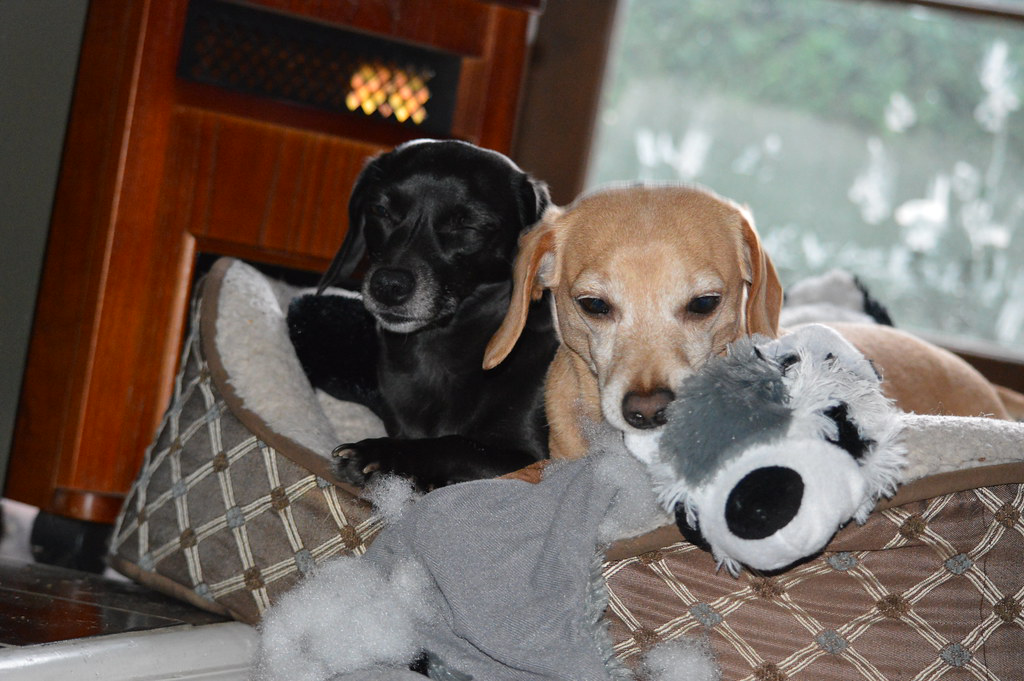

In [106]:
current_id = im_id
im_path = os.path.join('data/dogs-1024-2015', f"{current_id}.jpg")
im = Image.open(im_path)
im

In [108]:
bd_boxes[current_id]

KeyError: '16171984575'

In [ ]:
path = next(gen)
res = get_bounding_boxe(path)
im = Image.open(path)
boxe = res['detection_boxes'][0,0]
score = res['detection_scores'][0,0]
print(score.numpy())
get_face(boxe, im, aug_factor=0.1)

In [ ]:
def find_bdbox(images):
    test_images_np = [np.expand_dims(utils.load_image_into_numpy_array(p), axis=0) for p in images]
    preprocessed_images = []
    shapes = []
    for im in test_images_np:
        input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32)
        preprocessed_image, shape = detection_model.preprocess(input_tensor)
        shapes.apend(shape)
        preprocessed_images.append(preprocessed_image)
    tensor = tf.concat(preprocessed_images)
    prediction_dict = detection_model.predict(tensor, shapes)
    return detection_model.postprocess(prediction_dict, shapes)